In [7]:
import cv2
from utils import stabilize, subtract_background, morphological_segmentation, circularity_filter, eccentricity_filter, size_filter
import matplotlib.pyplot as plt
import numpy as np
VIDEOS_DIR = './videos'

In [8]:
cap = cv2.VideoCapture(VIDEOS_DIR + '/rally1.mp4')

# get first frame
ret, prev = cap.read()

# convert frame to grayscale
prev_gray = cv2.resize(cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY),(1300,500))

# create an ellipsoidal structuring element with a size of (5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 

# create a MOG2 background subrtractor
fgbg =cv2.createBackgroundSubtractorMOG2() 

# define the motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
 
# termination criteria for the optical flow algorithm
termination_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1e-3)

# initialize warp matrix
cc, warp_matrix = None,None

# list to store ball positions
ball_pos = []

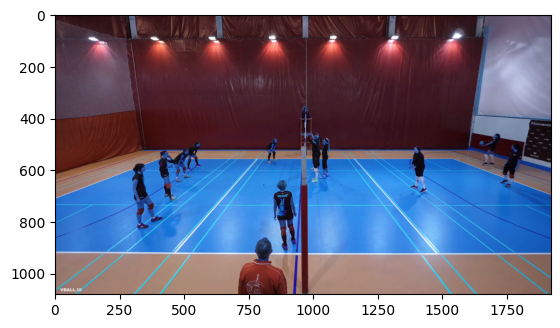

In [3]:
ret,frame = cap.read()

plt.imshow(frame)



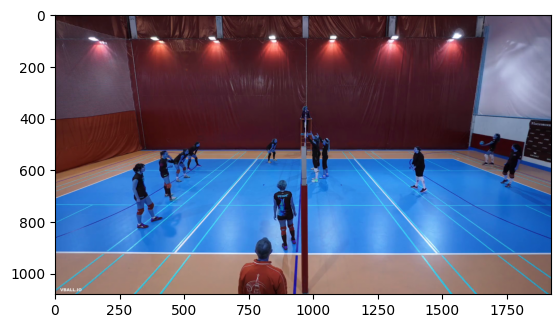

In [4]:
# convert the current frame to grayscale
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# equalize historgram of the grayscale frame
curr_gray = cv2.equalizeHist(gray)

# stabilization step
stabilized_frame = stabilize(frame, prev_gray, curr_gray, warp_matrix, warp_mode, termination_criteria)

plt.imshow(stabilized_frame)

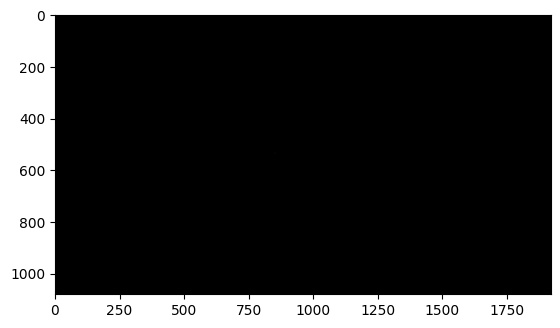

In [20]:
fgmask = subtract_background(stabilized_frame, fgbg)
plt.imshow(fgmask, cmap='gray')

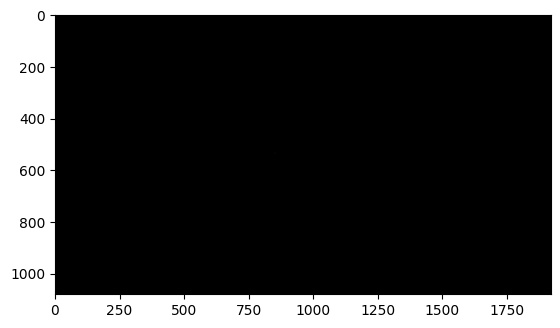

In [21]:
fgmask = morphological_segmentation(fgmask, kernel)
plt.imshow(fgmask, cmap='gray')

In [9]:
while True :
    ret,frame = cap.read()
    
    
    if not ret:
        break
        
    frame = cv2.resize(frame,(1300,500))
    
    # convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
    # equalize historgram of the grayscale frame
    curr_gray = cv2.equalizeHist(gray)

    # stabilization step
    stabilized_frame = stabilize(frame, prev_gray, curr_gray, warp_matrix, warp_mode, termination_criteria)
    
    # background subtraction step
    fgmask = subtract_background(stabilized_frame, fgbg)
    
    #morphological segmentation step
    fgmask = morphological_segmentation(fgmask, kernel)
    
    #cv2.imshow('foreground mask',fgmask)

    # Find contours in the foreground mask
    contours, _ = cv2.findContours(fgmask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    # possible candidate ball
    candidate_ball = None
    
    prev_gray = curr_gray
    
    
    for contour in contours:
            
        #apply circularity filter
        if circularity_filter(contour):
            candidate_ball =  contour
                
        #apply eccentricity filter
        elif eccentricity_filter(contour):
            candidate_ball = contour
            
        # filter out blobs which are either too big or too small
        if size_filter(contour, 20,60):
            candidate_ball = None
        
   
    if candidate_ball is not None: 
        
        # get the minimum enclosing circle for the candidate object
        (x, y), radius = cv2.minEnclosingCircle(candidate_ball)
        
        ball_pos.append(np.array([[x], [y]]))
        
        # draw red circle around the predicted ball
        cv2.circle(frame, (int(x),int(y)), int(radius), (0,255,0), 2)

    cv2.imshow('frame',frame)  
    
    if cv2.waitKey(10) == ord("q"): 
        break
    

cap.release()
cv2.destroyAllWindows()